# The QNLP Pipeline for Twitter Sentiment Analysis
## 1. Data Preprocess

In [1]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 7.4 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import collections
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
from random import shuffle
import re
import spacy
from discopy.tensor import Tensor
from discopy import Word
from discopy.rigid import Functor
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import random, unique
from lambeq import AtomicType, IQPAnsatz, remove_cups, NumpyModel, spiders_reader
from lambeq import BobcatParser, TreeReader, cups_reader, DepCCGParser
from lambeq import Dataset
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import TketModel
from lambeq import SpacyTokeniser
from pytket.extensions.qiskit import AerBackend


pd.set_option('display.width', 1000)
pd.options.display.max_colwidth=80
print(os.getcwd())
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
spacy.load('en_core_web_sm')

BATCH_SIZE = 30
EPOCHS = 100
SEED = 0
random.seed(SEED)

/app


In [3]:
def get_sent_length(sent):
    if type(sent) is not str:
        return 9999999
    word_list = sent.split(" ")
    return len(word_list)

columns = ["Id","Entity","Target","Text"]
data = pd.read_csv("/app/data/twitter_training.csv", names=columns,header=None)
#data = data.sample(frac=1).reset_index(drop=True)
data_val = pd.read_csv("/app/data/twitter_validation.csv", names=columns,header=None)
#data_val = data.sample(frac=1).reset_index(drop=True)
df_train = data[["Text","Target"]]
df_train = df_train.loc[(df_train["Target"]=='Positive') | (df_train["Target"]=='Negative') & (df_train["Text"]!=np.nan)&(df_train["Text"].map(get_sent_length)<=10)]
df_train= df_train.drop_duplicates()
df_val = data_val[['Text', 'Target']]
df_val = df_val.loc[(df_val['Target'] == 'Positive') | (df_val['Target'] == 'Negative') & (df_val["Text"]!=np.nan)&(df_val["Text"].map(get_sent_length)<=10)]
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub("'", " ", text)
    tokens = []
    for token in text.split():
            tokens.append(token)
    return " ".join(tokens)

df_train["Text"]= df_train["Text"].str.replace("im","i am")
df_train["Text"]= df_train["Text"].str.replace("don't","do not")
df_train["Text"]= df_train["Text"].str.replace("doesn't","does not")
df_train["Text"]= df_train["Text"].str.replace("won't","will not")
df_train["Text"]= df_train["Text"].str.replace("shouldn't","should not")
df_train["Text"]= df_train["Text"].str.replace("can't","can not")
df_train["Text"]= df_train["Text"].str.replace("couldn't","could not")
df_val["Text"] = df_val["Text"].str.replace("im","i am")
df_val["Text"] = df_val["Text"].str.replace("don't","do not")
df_val["Text"] = df_val["Text"].str.replace("doesn't","does not")
df_val["Text"] = df_val["Text"].str.replace("won't","will not")
df_val["Text"] = df_val["Text"].str.replace("shouldn't","should not")
df_val["Text"] = df_val["Text"].str.replace("can't","can not")
df_val["Text"] = df_val["Text"].str.replace("couldn't","could not")
df_train["Text"] = df_train["Text"].apply(preprocess)
df_val["Text"] = df_val["Text"].apply(preprocess)
df_train = df_train.dropna()
df_val = df_val.dropna()

negative_train_df = df_train.loc[df_train["Target"]=="Negative"]
positive_train_df = df_train.loc[df_train["Target"]=='Positive']

if len(positive_train_df)>=len(negative_train_df):
    positive_train_df = positive_train_df.head(len(negative_train_df))
else:
    negative_train_df = negative_train_df.head(len(positive_train_df))

negative_val_df = df_val.loc[df_val['Target'] == 'Negative']
positive_val_df = df_val.loc[df_val['Target'] == 'Positive']

if len(positive_val_df)>=len(negative_val_df):
    positive_val_df = positive_val_df.head(len(negative_val_df))
else:
    negative_val_df = negative_val_df.head(len(positive_val_df))

df_train = pd.concat([positive_train_df, negative_train_df])
df_val = pd.concat([positive_val_df, negative_val_df])

# Positive sentiment to [0,1], negative sentiment to [1,0]
sentiment_train = []
sentiment_val = []
for i in df_train["Target"]:
    if i == "Positive":
        sentiment_train.append([0,1])
    else:
        sentiment_train.append([1,0])

df_train["Sentiment"] = sentiment_train
        
for i in df_val["Target"]:
    if i == "Positive":
        sentiment_val.append([0,1])
    else:
        sentiment_val.append([1,0])

df_val["Sentiment"] = sentiment_val

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12688 entries, 0 to 74669
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       12688 non-null  object
 1   Target     12688 non-null  object
 2   Sentiment  12688 non-null  object
dtypes: object(3)
memory usage: 396.5+ KB


In [5]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 6 to 983
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       154 non-null    object
 1   Target     154 non-null    object
 2   Sentiment  154 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


In [6]:
df_train.head()

,Text,Target,Sentiment
0,i am getting on borderlands and i will murder you all,Positive,"[0, 1]"
1,i am coming to the borders and i will kill you all,Positive,"[0, 1]"
2,i am getting on borderlands and i will kill you all,Positive,"[0, 1]"
3,i am coming on borderlands and i will murder you all,Positive,"[0, 1]"
4,i am getting on borderlands 2 and i will murder you me all,Positive,"[0, 1]"


In [7]:
df_val.head()

,Text,Target,Sentiment
6,thank you eamaddennfl new te austin hooper in the orange brown browns austin...,Positive,"[0, 1]"
7,rocket league sea of thieves or rainbow six siege i love playing all three o...,Positive,"[0, 1]"
8,my ass still knee deep in assassins creed odyssey with no way out anyti ame ...,Positive,"[0, 1]"
10,the professional dota 2 scene is fucking exploding and i completely welcome ...,Positive,"[0, 1]"
11,itching to assassinate tccgif assassinscreedblackflag assassinscreed thecapt...,Positive,"[0, 1]"


<AxesSubplot:xlabel='Target', ylabel='count'>

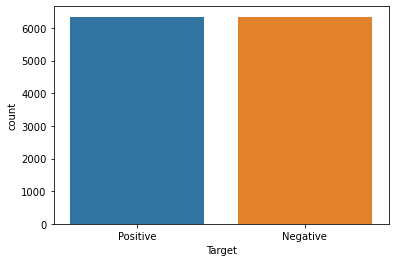

In [8]:
sns.countplot(x = "Target", data = df_train)

<AxesSubplot:xlabel='Target', ylabel='count'>

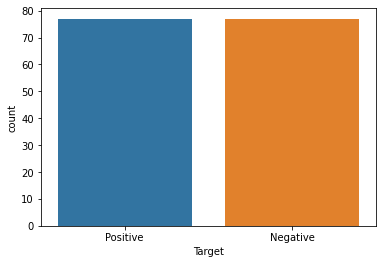

In [9]:
sns.countplot(x = "Target", data = df_val)

In [10]:
train_data_all, train_label_all = df_train["Text"].tolist(), df_train["Sentiment"].tolist()
dev_data, dev_labels = df_val["Text"].tolist(), df_val["Sentiment"].tolist()
data = train_data_all+dev_data
labels = train_label_all+dev_labels
pairs = []
for c in zip(labels, data):
    if len(c[1]) != 0 and len(c[1].split(" "))<=5:
        pairs.append(c)
random.seed(0)
random.shuffle(pairs)
N_EXAMPLES = len(pairs)
print("Total: {}".format(N_EXAMPLES))
TRAIN_RATIO_INDEX = 0.08
TEST_RATIO_INDEX = TRAIN_RATIO_INDEX + 0.01
DEV_RATIO_INDEX = TEST_RATIO_INDEX + 0.01
train_labels, train_data = zip(*pairs[:round(N_EXAMPLES * TRAIN_RATIO_INDEX)])
dev_labels, dev_data = zip(*pairs[round(N_EXAMPLES * TRAIN_RATIO_INDEX):round(N_EXAMPLES * TEST_RATIO_INDEX)])
test_labels, test_data = zip(*pairs[round(N_EXAMPLES * TEST_RATIO_INDEX):round(N_EXAMPLES * DEV_RATIO_INDEX)])
print("Data selected for train: {}\nData selected for test: {}\nData selected for dev: {}".format(len(train_data), len(test_data), len(dev_data)))

Total: 3918
Data selected for train: 313
Data selected for test: 39
Data selected for dev: 40


In [11]:
# Function for replacing low occuring word(s) with <unk> token
def replace(box):
    if isinstance(box, Word) and dataset.count(box.name) < 1:
        return Word('unk', box.cod, box.dom)
    return box

In [12]:
tokeniser = SpacyTokeniser()

In [13]:
train_data = tokeniser.tokenise_sentences(train_data)
dev_data = tokeniser.tokenise_sentences(dev_data)
test_data = tokeniser.tokenise_sentences(test_data)

In [14]:
for i in range(len(train_data)):
    train_data[i] = ' '.join(train_data[i])

for i in range(len(dev_data)):
    dev_data[i] = ' '.join(dev_data[i])

for i in range(len(test_data)):
    test_data[i] = ' '.join(test_data[i])

In [15]:
# training set words (with repetition)
train_data_string = ' '.join(train_data)
train_data_list = train_data_string.split(' ')
# validation set words (with repetition)
dev_data_string = ' '.join(dev_data)
dev_data_list = dev_data_string.split(' ')
# test set words (with repetition)
test_data_string = ' '.join(test_data)
test_data_list = test_data_string.split(' ')

In [16]:
# dataset words (with repetition)
dataset = train_data_list + dev_data_list + test_data_list
# list of all unique words in the dataset
unique_words = unique(dataset)
# frequency for each unique word
counter = collections.Counter(dataset)
#print(counter)

In [17]:
replace_functor = Functor(ob=lambda x: x, ar=replace)

In [18]:
#parser = BobcatParser(verbose='text')
print(BobcatParser.available_models())
parser = spiders_reader
#parser = DepCCGParser()
#parser = cups_reader

['bert']


In [19]:
raw_train_diagrams = []
new_train_labels = []
raw_dev_diagrams = []
new_dev_labels = []
raw_test_diagrams = []
new_test_labels = []
for sent, label in zip(train_data, train_labels):
    try:
        diag = parser.sentence2diagram(sent)
        raw_train_diagrams.append(diag)
        new_train_labels.append(label)
    except:
        print("Cannot be parsed in train: {}".format(sent))

for sent, label in zip(dev_data, dev_labels):
    try:
        diag = parser.sentence2diagram(sent)
        raw_dev_diagrams.append(diag)
        new_dev_labels.append(label)
    except:
        print("Cannot be parsed in dev: {}".format(sent))        


for sent, label in zip(test_data, test_labels):
    try:
        diag = parser.sentence2diagram(sent)
        raw_test_diagrams.append(diag)
        new_test_labels.append(label)
    except:
        print("Cannot be parsed in test: {}".format(sent))

train_labels = new_train_labels
dev_labels = new_dev_labels
test_labels = new_test_labels

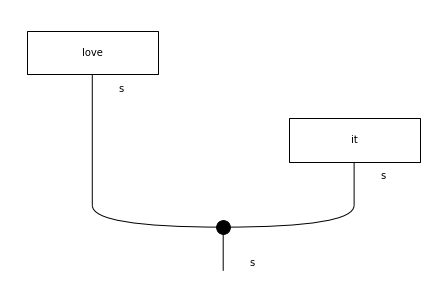

In [20]:
# # Tokenizing low occuring words in each dataset
for i in range(len(raw_train_diagrams)):
    raw_train_diagrams[i] = replace_functor(raw_train_diagrams[i])

for i in range(len(raw_dev_diagrams)):
    raw_dev_diagrams[i] = replace_functor(raw_dev_diagrams[i])

for i in range(len(raw_test_diagrams)):
    raw_test_diagrams[i] = replace_functor(raw_test_diagrams[i])

# sample sentence diagram (entry 1)
raw_train_diagrams[0].draw()

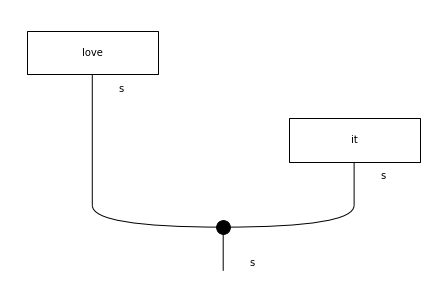

In [21]:
# merging all diagrams into one for checking the new words
raw_all_diagrams = raw_train_diagrams + raw_dev_diagrams + raw_test_diagrams

# removing cups (after performing top-to-bottom scan of the word diagrams)
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

# sample sentence diagram (entry 1)
train_diagrams[0].draw()

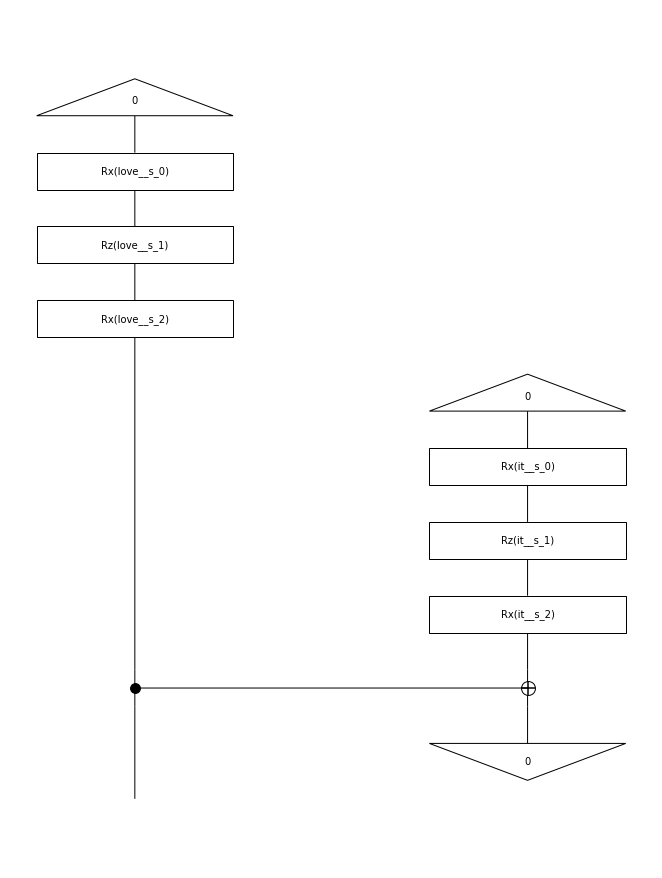

In [22]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.NOUN_PHRASE:1, AtomicType.CONJUNCTION:1}, n_layers=1, n_single_qubit_params=3)

# train/test circuits
train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits = [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

# sample circuit diagram
train_circuits[0].draw(figsize=(9, 12))

In [23]:
all_circuits = train_circuits + dev_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [24]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [25]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [26]:
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [ ]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)